## Demo code to run V1T on sensorium+ test set and extract attention rollout maps

Please follow the instruction in [README.md](README.md) to set up the conda environment.

In [1]:
import torch
import typing as t
from tqdm import tqdm
from torch.utils.data import DataLoader

from v1t import data
from v1t.utils import utils
from v1t.models import Model
from v1t.metrics import Metrics
from v1t.utils.scheduler import Scheduler

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
dev0 = torch.device("cuda:0")
dev1 =  torch.device("cuda:1")
dev2 = torch.device("cpu")

create dummy arg object to mimic argparse and load args from checkpoint.

In [5]:
class Args:
    def __init__(self):
        self.device = dev1
        self.batch_size = 16
        self.output_dir = "runs/cosine-similarity2"
        self.dataset = "data/sensorium"


args = Args()
utils.load_args(args)  # load arguments from checkpoint

load Sensorium dataset

In [6]:
train_ds, val_ds, test_ds = data.get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

initialize model and restore checkpoint

In [7]:
model = Model(args, ds=train_ds)
model.to(args.device)

scheduler = Scheduler(args, model=model, save_optimizer=False)
_ = scheduler.restore(force=True)

Enable gradient checkpointing in ViT

Loaded checkpoint from epoch 89 (correlation: 0.4344).



In [8]:
@torch.no_grad()
def inference(
    ds: DataLoader,
    model: torch.nn.Module,
    batch_size: int,
    device: torch.device = "cpu",
) -> t.Dict[str, torch.Tensor]:
    """Inference data in DataLoader ds
    Returns:
        results: t.Dict[int, t.Dict[str, torch.Tensor]]
            - mouse_id
                - predictions: torch.Tensor, predictions given images
                - targets: torch.Tensor, the ground-truth responses
                - trial_ids: torch.Tensor, trial ID of the responses
                - image_ids: torch.Tensor, image ID of the responses
    """
    results = {
        "predictions": [],
        "targets": [],
        "trial_ids": [],
        "image_ids": [],
    }
    mouse_id = ds.dataset.mouse_id
    model.to(device)
    model.train(False)
    for batch in tqdm(ds, desc=f"Mouse {mouse_id}"):
        for micro_batch in data.micro_batching(batch, batch_size=batch_size):
            predictions, _, _ = model(
                inputs=micro_batch["image"].to(device),
                mouse_id=mouse_id,
                behaviors=micro_batch["behavior"].to(device),
                pupil_centers=micro_batch["pupil_center"].to(device),
            )
            results["predictions"].append(predictions.cpu())
            results["targets"].append(micro_batch["response"])
            results["image_ids"].append(micro_batch["image_id"])
            results["trial_ids"].append(micro_batch["trial_id"])
    results = {
        k: torch.cat(v, dim=0) if isinstance(v[0], torch.Tensor) else v
        for k, v in results.items()
    }
    return results

In [9]:
for mouse_id in ["A", "B", "C", "D", "E"]:
    outputs = inference(
        ds=test_ds[mouse_id],
        model=model,
        batch_size=args.batch_size,
        device=args.device,
    )
    metrics = Metrics(ds=test_ds[mouse_id], results=outputs)

    single_trial_correlation = metrics.single_trial_correlation(per_neuron=False)
    correlation_to_average = metrics.correlation_to_average(per_neuron=False)
    print(
        f"single trial correlation: {single_trial_correlation:.03f}\n"
        f"correlation to average: {correlation_to_average:.03f}\n"
    )

Mouse A:   0%|          | 0/63 [00:00<?, ?it/s]

Mouse A: 100%|██████████| 63/63 [00:09<00:00,  6.71it/s]


single trial correlation: 0.384
correlation to average: 0.571



Mouse B: 100%|██████████| 63/63 [00:07<00:00,  7.90it/s]


single trial correlation: 0.446
correlation to average: 0.643



Mouse C: 100%|██████████| 62/62 [00:07<00:00,  7.83it/s]


single trial correlation: 0.411
correlation to average: 0.613



Mouse D: 100%|██████████| 63/63 [00:07<00:00,  7.92it/s]


single trial correlation: 0.420
correlation to average: 0.616



Mouse E: 100%|██████████| 63/63 [00:07<00:00,  7.88it/s]


single trial correlation: 0.387
correlation to average: 0.590



## Extract attention rollout maps for Mouse A

See [misc/vit_visualization.py](misc/vit_visualization.py) for more.

In [10]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from v1t.utils import tensorboard
from v1t.utils.attention_rollout import attention_rollouts, Recorder

tensorboard.set_font()

helper function to overlay attention rollout maps on input images

In [11]:
def plot_attention_maps(
    val_results: t.Dict[str, np.ndarray],
    test_results: t.Dict[str, np.ndarray],
    colormap: str = "turbo",
    alpha: float = 0.5,
):
    cmap = matplotlib.colormaps.get_cmap(colormap)
    colors = cmap(np.arange(256))[:, :3]
    label_fontsize, tick_fontsize = 10, 8
    labelpad = 2
    figure, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(8, 4),
        gridspec_kw={"wspace": 0.05, "hspace": -0.25},
        dpi=240,
    )
    for i in range(len(val_results["images"])):
        image = val_results["images"][i][0]
        heatmap = val_results["heatmaps"][i]
        behavior = val_results["behaviors"][i]
        pupil_center = val_results["pupil_centers"][i]
        heatmap = colors[np.uint8(255.0 * heatmap)] * 255.0
        heatmap = alpha * heatmap + (1 - alpha) * image[..., None]
        axes[0, i].imshow(heatmap.astype(np.uint8), cmap=colormap)
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        tensorboard.remove_spines(axis=axes[0, i])
        description = (
            f"[{behavior[0]:.01f}, "  # pupil dilation
            f"{behavior[1]:.01f}, "  # dilation derivative
            f"({pupil_center[0]:.01f}, {pupil_center[1]:.01f}), "  # pupil center
            f"{behavior[2]:.01f}]"  # speed
        )
        axes[0, i].set_xlabel(description, labelpad=labelpad, fontsize=tick_fontsize)
    axes[0, 0].set_ylabel(
        "Validation samples", labelpad=labelpad, fontsize=tick_fontsize
    )
    for i in range(len(test_results["images"])):
        image = test_results["images"][i][0]
        heatmap = test_results["heatmaps"][i]
        behavior = test_results["behaviors"][i]
        pupil_center = test_results["pupil_centers"][i]
        heatmap = colors[np.uint8(255.0 * heatmap)] * 255.0
        heatmap = alpha * heatmap + (1 - alpha) * image[..., None]
        axes[1, i].imshow(heatmap.astype(np.uint8), cmap=colormap)
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        tensorboard.remove_spines(axis=axes[1, i])
        description = (
            f"[{behavior[0]:.01f}, "  # pupil dilation
            f"{behavior[1]:.01f}, "  # dilation derivative
            f"({pupil_center[0]:.01f}, {pupil_center[1]:.01f}), "  # pupil center
            f"{behavior[2]:.01f}]"  # speed
        )
        axes[1, i].set_xlabel(description, labelpad=labelpad, fontsize=tick_fontsize)
    axes[-1, 0].set_ylabel("Test samples", labelpad=labelpad, fontsize=tick_fontsize)

    # plot colorbar
    pos1 = axes[0, -1].get_position()
    pos2 = axes[-1, -1].get_position()
    width, height = 0.008, (pos1.y1 - pos1.y0) * 0.35
    cbar_ax = figure.add_axes(
        rect=[
            pos1.x1 + 0.01,
            ((pos1.y1 - pos2.y0) / 2 + pos2.y0) - (height / 2),
            width,
            height,
        ]
    )
    figure.colorbar(cm.ScalarMappable(cmap=colormap), cax=cbar_ax, shrink=0.1)
    tensorboard.set_yticks(
        axis=cbar_ax,
        ticks_loc=np.linspace(0, 1, 3),
        tick_fontsize=tick_fontsize,
    )
    tensorboard.set_ticks_params(axis=cbar_ax)

    plt.show()

helper function to record outputs from scaled dot product attention and extract attention rollout maps

In [12]:
@torch.no_grad()
def extract_attention_maps(
    ds: DataLoader, model: Model, num_plots: int, device: torch.device = "cpu"
) -> t.Dict[str, np.ndarray]:
    model.to(device)
    model.train(False)

    mouse_id = ds.dataset.mouse_id
    i_transform_image = ds.dataset.i_transform_image
    i_transform_behavior = ds.dataset.i_transform_behavior
    i_transform_pupil_center = ds.dataset.i_transform_pupil_center

    recorder = Recorder(model.core)
    results = {"images": [], "heatmaps": [], "pupil_centers": [], "behaviors": []}
    count = num_plots
    for i, batch in enumerate(ds):
        images = batch["image"].to(device)
        behaviors = batch["behavior"].to(device)
        pupil_centers = batch["pupil_center"].to(device)
        images, _ = model.image_cropper(
            inputs=images,
            mouse_id=mouse_id,
            behaviors=behaviors,
            pupil_centers=pupil_centers,
        )
        _, attentions = recorder(
            images=images,
            behaviors=behaviors,
            pupil_centers=pupil_centers,
            mouse_id=mouse_id,
        )
        recorder.clear()

        # compute attention rollout maps within the loop to avoid OOM
        heatmaps = attention_rollouts(attentions, image_shape=images.shape[-2:])

        results["images"].append(i_transform_image(images.cpu()))
        results["heatmaps"].append(heatmaps.cpu())
        results["behaviors"].append(i_transform_behavior(behaviors.cpu()))
        results["pupil_centers"].append(i_transform_pupil_center(pupil_centers.cpu()))

        if (count := count - len(images)) <= 0:
            break

    recorder.eject()
    del recorder

    return {k: torch.vstack(v).numpy()[:num_plots] for k, v in results.items()}

In [13]:
mouse_id = "A"
num_plots = 3
val_results = extract_attention_maps(
    ds=val_ds[mouse_id],
    model=model,
    num_plots=num_plots,
    device= dev2,
)
test_results = extract_attention_maps(
    ds=test_ds[mouse_id],
    model=model,
    num_plots=num_plots,
    device=dev2,
)

In [14]:
print(val_results["heatmaps"])

[[[0.13253811 0.16672567 0.16517794 ... 0.26386064 0.25410903 0.26838332]
  [0.18387184 0.20505387 0.20620662 ... 0.14800964 0.16362284 0.1774569 ]
  [0.2153521  0.23965319 0.21529871 ... 0.09707039 0.10874461 0.13878216]
  ...
  [0.2219443  0.24536073 0.31031322 ... 0.14177993 0.12058615 0.11580078]
  [0.2279464  0.28901467 0.3915761  ... 0.17708108 0.17064866 0.12493026]
  [0.3349028  0.35786676 0.42650923 ... 0.22088991 0.25491858 0.15147537]]

 [[0.27336195 0.2183414  0.1336918  ... 0.8221861  0.82394993 0.8347592 ]
  [0.2561478  0.18561587 0.13124876 ... 0.78124213 0.7776764  0.7758368 ]
  [0.23190868 0.12783611 0.15773651 ... 0.65493315 0.66641283 0.6956094 ]
  ...
  [0.6484183  0.71039754 0.8190312  ... 0.16604555 0.21308951 0.26043162]
  [0.73769677 0.77884394 0.7502105  ... 0.1662828  0.22958314 0.24374631]
  [0.8774603  0.811195   0.53196806 ... 0.20758696 0.3425455  0.3950836 ]]

 [[0.20027733 0.33217704 0.36173967 ... 0.7131261  0.7668956  0.81889033]
  [0.19996521 0.320513

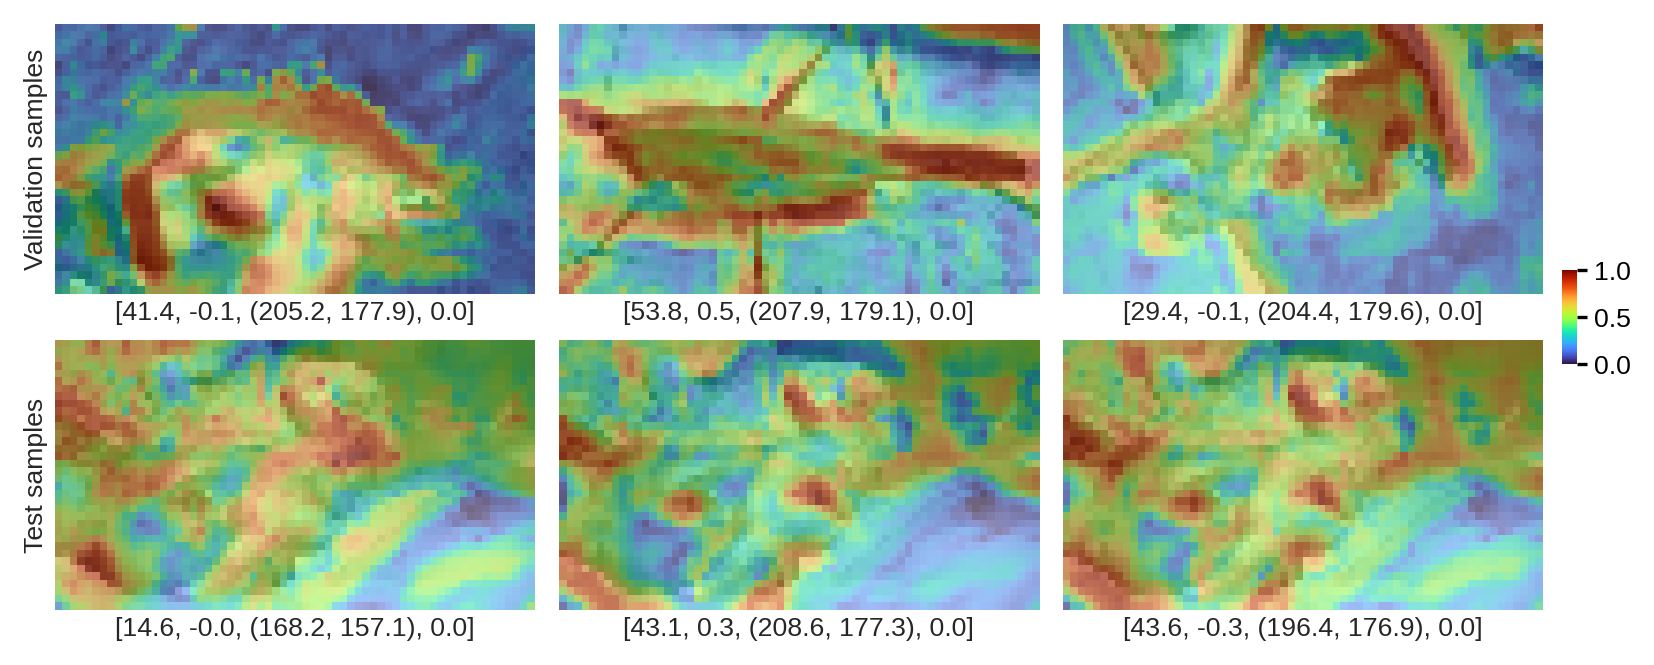

In [15]:
plot_attention_maps(val_results=val_results, test_results=test_results)

Please check [misc/](misc/) for code to generate plots and figures used in the paper.

In [17]:
import gc
gc.collect()

28481

In [18]:
import torch
torch.cuda.empty_cache()